In [1]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from tensorflow.keras.datasets import imdb
from konlpy.tag import Twitter
from konlpy.tag import Okt
from konlpy.tag import Kkma 
from konlpy.tag import Twitter
from pprint import pprint
import nltk
from nltk.classify.scikitlearn import SklearnClassifier
from wordcloud import WordCloud, STOPWORDS
from gensim import corpora, models
import numpy  as np
from PIL import Image
from wordcloud import ImageColorGenerator
import glob
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline


In [3]:
ko_str = '이것은 한국어 문장입니다.'
ja_str = 'これは日本語の文章です。'
en_str = 'This is English Sentences.'
ch_str = '统一码'

In [7]:
print(ko_str[0] , ko_str[1])
print(ja_str[0] , ja_str[1])
print(en_str[0] , en_str[1])
print(ch_str[0] , ch_str[1])

이 것
こ れ
T h
统 一


In [2]:
#모든 코드는 0~65535 에 기록되어 있다. 유니코드는 모두 2byte
print(ord(ko_str[0]))
print(ord(ja_str[0]))
print(ord(en_str[0]))
print(ord(ch_str[0]))

51060
12371
84
32479


In [12]:
#문장을 히스토그램으로 표시하기 위한 함수
# Unicode 코드 포인트로 출현 빈도 판정하기 --- (*1)    
def count_codePoint(str):
    # Unicode 코드 포인트를 저장할 배열 준비하기 --- (*2)
    counter = np.zeros(65535)
    for i in range(len(str)):
        # 각 문자를 Unicode 코드 포인트로 변환하기 --- (*3)
        code_point = ord(str[i])
        if code_point > 65535 :
            continue
        # 출현 횟수 세기 --- (*4)
        counter[code_point] += 1

    # 각 요소를 문자 수로 나눠 정규화하기 --- (*5)
    counter = counter/len(str)
    return counter

In [13]:
# 학습 전용 데이터 준비하기
ko_str = '이것은 한국어 문장입니다.'
ja_str = 'これは日本語の文章です。'
en_str = 'This is English Sentences.'

x_train = [count_codePoint(ko_str),count_codePoint(ja_str),count_codePoint(en_str)]
y_train = ['ko','ja','en']

In [28]:
print(x_train[0])
print(np.where(x_train[0] > 0)) # np.where() 0보다 큰 값의 인덱스를 리턴

[0. 0. 0. ... 0. 0. 0.]
(array([   32,    46, 44163, 44397, 45768, 45796, 47928, 50612, 51008,
       51060, 51077, 51109, 54620], dtype=int64),)


In [29]:
idx = np.where(x_train[0] > 0)
data = x_train[0]
print(data[idx])

[0.14285714 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.07142857]


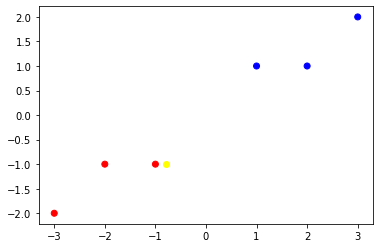

In [31]:
#X = np.array([[-1, -1], [3, 2]])
#Y = np.array([1,  2])

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

#Y = np.array([1, 1, 1, 2, 2, 2])
#color = [ 'red' if y == 1 else 'blue' for y in Y]
Y = np.array(['r', 'r', 'r', 2, 2, 2])
color = [ 'red' if y == 'r' else 'blue' for y in Y]


plt.scatter(X[:, 0], X[:, 1], color=color)
t = np.array([[-0.8, -1]])
plt.scatter(t[:,0], t[:,1], color='yellow')

In [32]:
clf = GaussianNB() #https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
clf.fit(X, Y)
print(clf.predict([[-0.8, -1]]))

['r']


In [33]:
clf.fit([[0,0], [0,1], [1,0], [1,1]], [0,1,1,0])
print(clf.predict([[0, 1]]))

[0]


In [45]:
# 학습하기 --- (*6)
clf = GaussianNB() 
clf.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [38]:
y_pred = clf.predict([count_codePoint('안녕. 어디야')]) #특징을 65535 차원으로 변경, 단어의 분포도를 보고 언어예측
print(y_pred)

['ko']


In [50]:
# 평가 전용 데이터 준비하기
ko_test_str = '안녕. 반가워'
ja_test_str = 'こんにちは'
en_test_str = 'Hello'
x_test = [count_codePoint(en_test_str),count_codePoint(ja_test_str),count_codePoint(ko_test_str)]
y_test = ['en','ja','ko']

# 평가하기 --- (*7)
y_pred = clf.predict(x_test)
print(y_test)
print(y_pred)
print("정답률 = " , accuracy_score(y_test, y_pred))

['en', 'ja', 'ko']
['en' 'ja' 'ko']
정답률 =  1.0


In [55]:
# 평가 데이터 준비하기 --- (*4)
x_test = []
y_test = []
for file in glob.glob('language/test/*.txt'):
    print(file)
    # 언어 정보를 추출하고 레이블로 지정하기
    y_test.append(file[7:9])
    
    # 파일 내부의 문자열을 모두 추출한 뒤 빈도 배열로 변환한 뒤 입력 데이터로 사용하기
    file_str = ''
    for line in open(file, 'r', encoding='UTF8'):
        file_str = file_str + line
    x_test.append(count_codePoint(file_str)) 
print(x_test)
print(y_test)
    
# 평가하기
y_pred = clf.predict(x_test)
print(y_pred)
print("정답률 = " , accuracy_score(y_test, y_pred))

language/test\de_lion.txt
language/test\en_lion.txt
language/test\es_lion.txt
[array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.])]
['e/', 'e/', 'e/']
['en' 'en' 'en']
정답률 =  0.0


In [77]:
corpus = [
    'you know I want your love',                
    'I like you',
    'what should I do ',  
    'what should ',    
    'should what '
]

In [78]:
str = " ".join(corpus)
print(str)
words = str.split(' ')
print(words)
freq = {}
for w in words :
    freq[w] = freq.get(w, 0) + 1 # dict 안에 값이 있으면 +1 없으면 0으로 설정
print(freq)    

you know I want your love I like you what should I do  what should  should what 
['you', 'know', 'I', 'want', 'your', 'love', 'I', 'like', 'you', 'what', 'should', 'I', 'do', '', 'what', 'should', '', 'should', 'what', '']
{'you': 2, 'know': 1, 'I': 3, 'want': 1, 'your': 1, 'love': 1, 'like': 1, 'what': 3, 'should': 3, 'do': 1, '': 3}


In [79]:
vector = CountVectorizer() #카운터벡터라이저 원핫 인코딩 해주는 함수
tf = vector.fit_transform(corpus) # 불피요한 단어(단어 하나인애들)를 빼고 전체 단어를 가져온다
print(tf.shape) # 5,9 문장 5개 , 단어수 9개
print(tf)
print(tf.toarray())

(5, 9)
  (0, 7)	1
  (0, 1)	1
  (0, 5)	1
  (0, 8)	1
  (0, 3)	1
  (1, 7)	1
  (1, 2)	1
  (2, 6)	1
  (2, 4)	1
  (2, 0)	1
  (3, 6)	1
  (3, 4)	1
  (4, 6)	1
  (4, 4)	1
[[0 1 0 1 0 1 0 1 1]
 [0 0 1 0 0 0 0 1 0]
 [1 0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 1 0 0]]


In [80]:
print(vector.vocabulary_) # 각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.

{'you': 7, 'know': 1, 'want': 5, 'your': 8, 'love': 3, 'like': 2, 'what': 6, 'should': 4, 'do': 0}


In [72]:
print(vector.vocabulary_['you'])
print(vector.vocabulary_.get('you'))   

7
7


In [73]:
words = vector.get_feature_names()
for word in words: print(word)
    
for key in vector.vocabulary_: 
    print(key, vector.vocabulary_[key])

do
know
like
love
should
want
what
you
your
you 7
know 1
want 5
your 8
love 3
like 2
what 6
should 4
do 0


# TF-IDF ( Term Frequency - Inverse Document Frequency)

- TF : 현재 문서에서 단어 A가 나타난 횟수 ( 해당 단어가 많을 수록 중요하다는 뜻)
- DF : 단어가 나타난 문서의 수( 높으면 해당 단어가 흔하다는 뜻, 중요하지 않다는 뜻, 낮으면 특정 문서에서만 쓰인다는 뜻)
- 특정 단어의 상대적인 빈도를 나타내주는 값
- 값이 클 수록 **내 문서**에만 많이 언급되는 단어(=다른 문서에서는 잘 언급 안됨)
- 값이 작을수록 다른 문서에 잘 언급하는 단어를 의미(=현재 문서와 관련 없음)
- TF-IDF = TF * log(N/DF) N은 문서의 건 수


In [81]:
sent = ["오늘 휴일", 
        "휴일 오늘", 
        "휴일 인 오늘 도 서쪽 을 중심 으로 폭염 이 이어졌는데요, 내일 은 반가운 비 소식 이 있습니다.", 
        "폭염 을 피해서 휴일 에 놀러왔다가 갑작스런 비 로 인해 망연자실 하고 있습니 다.", 
        " 내일 은 반가운 비 소식 이 있습니다."] 

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sent) #문장 벡터화 진행
print(tfidf_matrix)

  (0, 17)	0.6437444595062429
  (0, 7)	0.7652405313723362
  (1, 17)	0.6437444595062429
  (1, 7)	0.7652405313723362
  (2, 12)	0.28487998702172107
  (2, 6)	0.28487998702172107
  (2, 4)	0.28487998702172107
  (2, 1)	0.28487998702172107
  (2, 9)	0.35310140100264525
  (2, 14)	0.28487998702172107
  (2, 8)	0.35310140100264525
  (2, 13)	0.35310140100264525
  (2, 5)	0.35310140100264525
  (2, 17)	0.19893117008503197
  (2, 7)	0.23647612349029334
  (3, 11)	0.3542556015420614
  (3, 16)	0.3542556015420614
  (3, 3)	0.3542556015420614
  (3, 10)	0.3542556015420614
  (3, 0)	0.3542556015420614
  (3, 2)	0.3542556015420614
  (3, 15)	0.3542556015420614
  (3, 14)	0.28581118874948447
  (3, 17)	0.1995814265359179
  (4, 12)	0.5
  (4, 6)	0.5
  (4, 4)	0.5
  (4, 1)	0.5


In [82]:
print(type(tfidf_matrix))
print(tfidf_matrix.toarray().shape)
print(tfidf_matrix.toarray())
#내문장에서만 발현빈도수가 높은게 tfidf, 다른문서에서 언급이 안될 수록 높음

<class 'scipy.sparse.csr.csr_matrix'>
(5, 18)
[[0.         0.         0.         0.         0.         0.
  0.         0.76524053 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.64374446]
 [0.         0.         0.         0.         0.         0.
  0.         0.76524053 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.64374446]
 [0.         0.28487999 0.         0.         0.28487999 0.3531014
  0.28487999 0.23647612 0.3531014  0.3531014  0.         0.
  0.28487999 0.3531014  0.28487999 0.         0.         0.19893117]
 [0.3542556  0.         0.3542556  0.3542556  0.         0.
  0.         0.         0.         0.         0.3542556  0.3542556
  0.         0.         0.28581119 0.3542556  0.3542556  0.19958143]
 [0.         0.5        0.         0.         0.5        0.
  0.5        0.         0.         0.         0.         0.
  0.5        0.         0.         0.         0.         0.     

In [89]:
words = tfidf_vectorizer.get_feature_names()
print(words)

['갑작스런', '내일', '놀러왔다가', '망연자실', '반가운', '서쪽', '소식', '오늘', '으로', '이어졌는데요', '인해', '있습니', '있습니다', '중심', '폭염', '피해서', '하고', '휴일']


In [101]:
mat = np.asarray(tfidf_matrix.toarray())
srch=['오늘', '휴일']
print([  tfidf_vectorizer.vocabulary_.get(i) for i in srch])

srch_dtm = mat[:, [  tfidf_vectorizer.vocabulary_.get(i) for i in srch]]

#srch_dtm = mat[:, [ 7,17]]   
#srch_dtm = mat[:, 7]   

print(srch_dtm)

[7, 17]
[[0.76524053 0.64374446]
 [0.76524053 0.64374446]
 [0.23647612 0.19893117]
 [0.         0.19958143]
 [0.         0.        ]]


In [94]:
score = srch_dtm.sum(axis=1)
print(score)

for i in range(len(score)):
    if score[i] > 0:
        print('{} / score : {}'.format(sent[i], score[i]))  

[0.76524053 0.76524053 0.52135611 0.28581119 0.        ]
오늘 휴일 / score : 0.7652405313723362
휴일 오늘 / score : 0.7652405313723362
휴일 인 오늘 도 서쪽 을 중심 으로 폭염 이 이어졌는데요, 내일 은 반가운 비 소식 이 있습니다. / score : 0.5213561105120144
폭염 을 피해서 휴일 에 놀러왔다가 갑작스런 비 로 인해 망연자실 하고 있습니 다. / score : 0.28581118874948447


In [95]:
sentences = ['This is the first document.',
              'This is the second document.',
              'And the third one.',
              'Is this the first document?']
vect = TfidfVectorizer()
X = vect.fit_transform(sentences)

In [96]:
y = [1,2,3,4]
model =  SGDClassifier(loss='perceptron')  
model.fit(X, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='perceptron',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [97]:
X_pred = vect.transform(['My new document third'])
y_pred = model.predict(X_pred)
print(y_pred)

[3]
